In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, math

TABLES_DIRECTORY = "../../Data/giant_tables"

In [3]:
patient_hup_ids = []
# Iterate through all files in TABLES_DIRECTORY
for filename in os.listdir(TABLES_DIRECTORY):
    # Only look at filename that are .csv files and does not begin with .
    if filename.endswith(".csv") and not filename.startswith("."):
        # Get the patient_hup_id from the filename which is after _ and before .
        patient_hup_id = filename.split("_")[1].split(".")[0]
        patient_hup_ids.append(patient_hup_id)

patient_hup_ids = sorted(patient_hup_ids)
len(patient_hup_ids)

62

In [4]:
def find_taper_periods(hourly_patient_features_df):
    # Drop the 'med_lorazepam_raw' column
    hourly_patient_features_df = hourly_patient_features_df.drop('med_lorazepam_raw', axis=1)

    # Drop columns that are all zeros
    hourly_patient_features_df = hourly_patient_features_df.loc[:, (hourly_patient_features_df != 0).any(axis=0)]

    # Drop rows where 'awake' column is 0
    hourly_patient_features_df = hourly_patient_features_df[hourly_patient_features_df.awake != 0]

    # Find rows where 'num_seizures' is greater than 0 and drop them and three rows before and after
    seizure_rows = hourly_patient_features_df.index[hourly_patient_features_df['num_seizures'] > 0].tolist()
    drop_rows = []
    for row in seizure_rows:
        drop_rows.extend(list(range(row - 3, row + 4)))

    # Make sure all rows to drop are within dataframe index range
    drop_rows = [row for row in drop_rows if row in hourly_patient_features_df.index]
    hourly_patient_features_df = hourly_patient_features_df.drop(drop_rows)

    # Find the first 'emu_hour' where both 'teager_energy' and 'kuramoto' are not nan
    start_point = hourly_patient_features_df[(~hourly_patient_features_df['teager_energy'].isna()) & (~hourly_patient_features_df['kuramoto'].isna())].emu_hour.min()

    # Get medication columns
    med_columns = [col for col in hourly_patient_features_df.columns if col.startswith('med_')]

    # Find the peak values of each medication within the first 24 'emu_hour' starting from 'start_point'
    peak_values = hourly_patient_features_df[(hourly_patient_features_df['emu_hour'] >= start_point) & (hourly_patient_features_df['emu_hour'] < start_point + 24)][med_columns].max()

    # Search for the first 'emu_hour' for which at least one medication drops below 40% of its corresponding peak value
    taper_start = hourly_patient_features_df[(hourly_patient_features_df['emu_hour'] >= start_point + 12) & (hourly_patient_features_df[med_columns] < peak_values * 0.5).any(axis=1)].emu_hour.min()

    # Assign the variable 'before_taper_period'
    before_taper_period = (start_point, taper_start)

    # Assign the variable 'after_taper_period'
    after_taper_period = (taper_start + 24, taper_start + 24 + 48)

    return before_taper_period, after_taper_period

In [5]:
def plot_stuff(hourly_patient_features_df, before_taper_period, after_taper_period):
    med_cols = [
        col
        for col in hourly_patient_features_df.columns
        if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
    ]
    med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

    fig, ax = plt.subplots(6, 1, figsize=(10, 10), sharex=True)

    for i, col in enumerate(med_cols):
        if col != "med_sum_no_lorazepam_raw":
            label = med_cols_no_raw[i].replace("med_", "")
            normalized_data = (
                hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
            )
            ax[0].plot(
                hourly_patient_features_df["emu_hour"], normalized_data, label=label
            )

    # Adding horizontal bars
    ax[0].hlines(1, before_taper_period[0], before_taper_period[1], color='green', linewidth=2)
    ax[0].hlines(1, after_taper_period[0], after_taper_period[1], color='red', linewidth=2)

    # Adding text annotations
    ax[0].text((before_taper_period[0] + before_taper_period[1]) / 2, 1, 'before taper', ha='center', va='bottom')
    ax[0].text((after_taper_period[0] + after_taper_period[1]) / 2, 1, 'after taper', ha='center', va='bottom')

    awake_hours = hourly_patient_features_df[hourly_patient_features_df["awake"] == 1][
        "emu_hour"
    ].values
    for idx in awake_hours:
        ax[0].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)

    seizure_hours = hourly_patient_features_df[
        hourly_patient_features_df["num_seizures"] >= 1
    ]["emu_hour"].values
    for idx in seizure_hours:
        ax[0].axvline(x=idx, color="red", linestyle="dotted")

    ax[0].set_ylabel("Normalized Load")
    # set y min and max to be 0 and 1.3
    ax[0].set_ylim([0, 1.3])
    ax[0].legend()
    ax[0].set_title("Individial AEDs")

    # New subplot for "med_sum_no_lorazepam_raw" titled as "Total AED"
    ax[1].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["med_sum_no_lorazepam_raw"],
    )
    ax[1].set_ylabel("Total AED")
    ax[1].set_title("Total AED")
    
    ax[2].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["spikes_sum_all"],
    )
    for idx in awake_hours:
        ax[2].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[2].axvline(x=idx, color="red", linestyle="dotted")

    ax[2].set_ylabel("Total Spikes")
    ax[2].set_title("All Spikes")

    ax[3].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["spikes_sum_soz"],
    )
    for idx in awake_hours:
        ax[3].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[3].axvline(x=idx, color="red", linestyle="dotted")

    ax[3].set_ylabel("Total Spikes")
    ax[3].set_title("SOZ Spikes")

    ax[4].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["teager_energy"],
    )
    for idx in awake_hours:
        ax[4].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[4].axvline(x=idx, color="red", linestyle="dotted")

    ax[4].set_ylabel("Teager Energy")
    ax[4].set_title("Teager Energy (Delta Band)")

    ax[5].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["kuramoto"],
    )
    for idx in awake_hours:
        ax[5].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[5].axvline(x=idx, color="red", linestyle="dotted")

    ax[5].set_ylabel("R")
    ax[5].set_title("Kuramoto Order Parameter (Delta Band)")

    ax[5].set_xlabel("Time (hours)")

    # max_hour = np.max(hourly_patient_features_df["emu_hour"])
    # ax[5].set_xticks(range(0, max_hour + 1, 24))
    # ax[5].set_xticklabels(
    #     ["Day " + str(i // 24 + 1) for i in range(0, max_hour + 1, 24)]
    # )

    plt.tight_layout()
    plt.show()


## Plot all time series

In [ ]:
for patient_hup_id in patient_hup_ids:
    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(os.path.join(TABLES_DIRECTORY, f"HUP_{patient_hup_id}.csv"))
    before_taper_period, after_taper_period = find_taper_periods(hourly_patient_features_df)

    # If any value in before_taper_period or after_taper_period is nan, skip this patient
    if np.isnan(before_taper_period[0]) or np.isnan(before_taper_period[1]) or np.isnan(after_taper_period[0]) or np.isnan(after_taper_period[1]):
        print(f"Patient {patient_hup_id} has nan values in before_taper_period or after_taper_period")
        continue
    
    print(f"Patient {patient_hup_id} before taper period: {before_taper_period} after taper period: {after_taper_period}")
    plot_stuff(hourly_patient_features_df, before_taper_period, after_taper_period)

## Teager energy before/after taper

Patient 141 has nan values in before_taper_period or after_taper_period
Patient 154 has nan values in before_taper_period or after_taper_period
Patient 175 has nan values in before_taper_period or after_taper_period


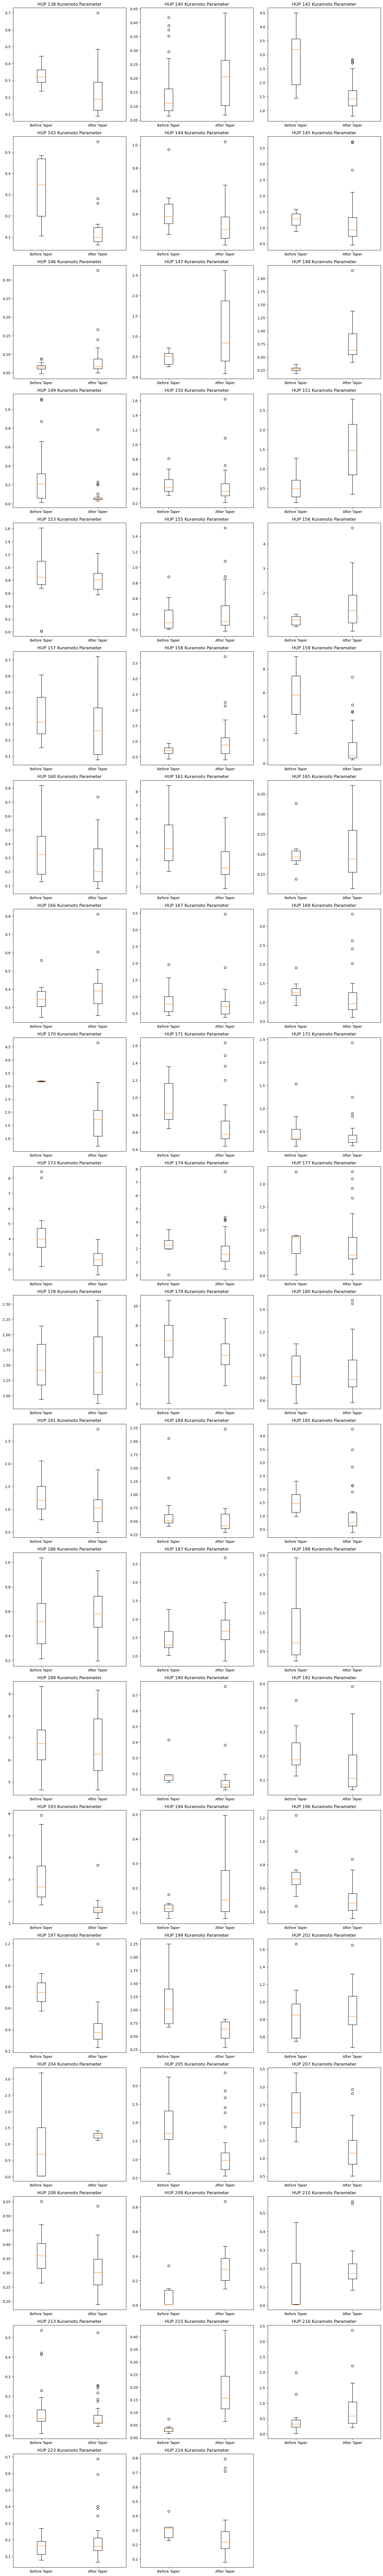

The mean of after_taper is smaller than the mean of before_taper for 37 patients.


In [7]:
# Calculate the number of rows needed based on the length of patient_hup_ids
num_rows = math.ceil(len(patient_hup_ids) / 3)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Initialize counters
count = 0
match_expectation_counter = 0

for patient_hup_id in patient_hup_ids:
    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(os.path.join(TABLES_DIRECTORY, f"HUP_{patient_hup_id}.csv"))
    before_taper_period, after_taper_period = find_taper_periods(hourly_patient_features_df)

    # If any value in before_taper_period or after_taper_period is nan, skip this patient
    if np.isnan(before_taper_period[0]) or np.isnan(before_taper_period[1]) or np.isnan(after_taper_period[0]) or np.isnan(after_taper_period[1]):
        print(f"Patient {patient_hup_id} has nan values in before_taper_period or after_taper_period")
        continue

    # Drop the 'med_lorazepam_raw' column
    hourly_patient_features_df = hourly_patient_features_df.drop('med_lorazepam_raw', axis=1)

    # Drop columns that are all zeros
    hourly_patient_features_df = hourly_patient_features_df.loc[:, (hourly_patient_features_df != 0).any(axis=0)]

    # Drop rows where 'awake' column is 0
    hourly_patient_features_df = hourly_patient_features_df[hourly_patient_features_df.awake != 0]

    # Find rows where 'num_seizures' is greater than 0 and drop them and three rows before and after
    seizure_rows = hourly_patient_features_df.index[hourly_patient_features_df['num_seizures'] > 0].tolist()
    drop_rows = []
    for row in seizure_rows:
        drop_rows.extend(list(range(row - 3, row + 4)))

    # Remove seizure rows
    hourly_patient_features_df = hourly_patient_features_df.drop(drop_rows, errors='ignore')

    # Get the 'emu_hour' and 'teager_energy' rows within the before and after taper periods
    before_taper = hourly_patient_features_df.loc[(hourly_patient_features_df['emu_hour'] >= before_taper_period[0]) & (hourly_patient_features_df['emu_hour'] <= before_taper_period[1]), 'teager_energy']
    after_taper = hourly_patient_features_df.loc[(hourly_patient_features_df['emu_hour'] >= after_taper_period[0]) & (hourly_patient_features_df['emu_hour'] <= after_taper_period[1]), 'teager_energy']

    # Remove nan values
    before_taper = before_taper.dropna()
    after_taper = after_taper.dropna()

    # if patient_hup_id == "188":
    #     break
    
    # Check if the mean of before_taper is larger than the mean of after_taper
    if after_taper.mean() < before_taper.mean():
        match_expectation_counter += 1

    # Create box plots
    row = count // 3
    col = count % 3
    axs[row, col].boxplot([before_taper, after_taper], labels=['Before Taper', 'After Taper'])
    axs[row, col].set_title(f'HUP {patient_hup_id} Kuramoto Parameter')

    count += 1

# Remove unused subplots
for i in range(count, num_rows * 3):
    fig.delaxes(axs.flatten()[i])

# Adjust spacing
plt.tight_layout()

# Show the plot
plt.show()

# Print the counter for patients where the mean of before_taper is larger than the mean of after_taper
print(f'The mean of after_taper is smaller than the mean of before_taper for {match_expectation_counter} patients.')


## Kuramoto order parameter before/after taper

In [10]:
# Calculate the number of rows needed based on the length of patient_hup_ids
num_rows = math.ceil(len(patient_hup_ids) / 3)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Initialize counters
count = 0
match_expectation_counter = 0

for patient_hup_id in patient_hup_ids:
    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(os.path.join(TABLES_DIRECTORY, f"HUP_{patient_hup_id}.csv"))
    before_taper_period, after_taper_period = find_taper_periods(hourly_patient_features_df)

    # If any value in before_taper_period or after_taper_period is nan, skip this patient
    if np.isnan(before_taper_period[0]) or np.isnan(before_taper_period[1]) or np.isnan(after_taper_period[0]) or np.isnan(after_taper_period[1]):
        print(f"Patient {patient_hup_id} has nan values in before_taper_period or after_taper_period")
        continue

    # Drop the 'med_lorazepam_raw' column
    hourly_patient_features_df = hourly_patient_features_df.drop('med_lorazepam_raw', axis=1)

    # Drop columns that are all zeros
    hourly_patient_features_df = hourly_patient_features_df.loc[:, (hourly_patient_features_df != 0).any(axis=0)]

    # Drop rows where 'awake' column is 0
    hourly_patient_features_df = hourly_patient_features_df[hourly_patient_features_df.awake != 0]

    # Find rows where 'num_seizures' is greater than 0 and drop them and three rows before and after
    seizure_rows = hourly_patient_features_df.index[hourly_patient_features_df['num_seizures'] > 0].tolist()
    drop_rows = []
    for row in seizure_rows:
        drop_rows.extend(list(range(row - 3, row + 4)))

    # Remove seizure rows
    hourly_patient_features_df = hourly_patient_features_df.drop(drop_rows, errors='ignore')

    # Get the 'emu_hour' and 'kuramoto' rows within the before and after taper periods
    before_taper = hourly_patient_features_df.loc[(hourly_patient_features_df['emu_hour'] >= before_taper_period[0]) & (hourly_patient_features_df['emu_hour'] <= before_taper_period[1]), 'kuramoto']
    after_taper = hourly_patient_features_df.loc[(hourly_patient_features_df['emu_hour'] >= after_taper_period[0]) & (hourly_patient_features_df['emu_hour'] <= after_taper_period[1]), 'kuramoto']

    # Remove nan values
    before_taper = before_taper.dropna()
    after_taper = after_taper.dropna()

    # if patient_hup_id == "188":
    #     break
    
    # Check if the mean of before_taper is larger than the mean of after_taper
    if after_taper.mean() > before_taper.mean():
        match_expectation_counter += 1

    # Create box plots
    row = count // 3
    col = count % 3
    axs[row, col].boxplot([before_taper, after_taper], labels=['Before Taper', 'After Taper'])
    axs[row, col].set_title(f'HUP {patient_hup_id} Kuramoto Parameter')

    count += 1

# Remove unused subplots
for i in range(count, num_rows * 3):
    fig.delaxes(axs.flatten()[i])

# Adjust spacing
plt.tight_layout()

# Show the plot
plt.show()

# Print the counter for patients where the mean of before_taper is larger than the mean of after_taper
print(f'The mean of after_taper is larger than the mean of before_taper for {match_expectation_counter} patients.')
